In [146]:
import requests
import pandas as pd
from pathlib import Path
import numpy as np
import io
import os
from lightkurve import search_targetpixelfile
import  matplotlib.pyplot as plt
import lightkurve as lk
from tqdm import tqdm
import concurrent.futures
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import (
	accuracy_score,
	classification_report,
	roc_auc_score,
	average_precision_score
)
import tensorflow as tf



pd.set_option('display.max_rows', None)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_seq_items', None)
pd.set_option('display.width', None)
%matplotlib inline

import random, os
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [147]:

BASE_URL = "https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query="

QUERY = "select * from cumulative"
requestUrl = BASE_URL + QUERY.replace(' ', '+') + '&format=csv'
koiDf = pd.read_csv(requestUrl)

koiDf.to_csv('koi.csv', index=False)
koiDf.head()





,kepid,kepoi_name,kepler_name,ra,ra_err,ra_str,dec,dec_err,dec_str,koi_gmag,koi_gmag_err,koi_rmag,koi_rmag_err,koi_imag,koi_imag_err,koi_zmag,koi_zmag_err,koi_jmag,koi_jmag_err,koi_hmag,koi_hmag_err,koi_kmag,koi_kmag_err,koi_kepmag,koi_kepmag_err,koi_delivname,koi_vet_stat,koi_quarters,koi_disposition,koi_pdisposition,koi_count,koi_num_transits,koi_max_sngle_ev,koi_max_mult_ev,koi_bin_oedp_sig,koi_limbdark_mod,koi_ldm_coeff4,koi_ldm_coeff3,koi_ldm_coeff2,koi_ldm_coeff1,koi_trans_mod,koi_model_snr,koi_model_dof,koi_model_chisq,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_eccen,koi_eccen_err1,koi_eccen_err2,koi_longp,koi_longp_err1,koi_longp_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_sma,koi_sma_err1,koi_sma_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_ingress,koi_ingress_err1,koi_ingress_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_period,koi_period_err1,koi_period_err2,koi_ror,koi_ror_err1,koi_ror_err2,koi_dor,koi_dor_err1,koi_dor_err2,koi_incl,koi_incl_err1,koi_incl_err2,koi_teq,koi_teq_err1,koi_teq_err2,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_smet,koi_smet_err1,koi_smet_err2,koi_srad,koi_srad_err1,koi_srad_err2,koi_smass,koi_smass_err1,koi_smass_err2,koi_sage,koi_sage_err1,koi_sage_err2,koi_sparprov,koi_fwm_stat_sig,koi_fwm_sra,koi_fwm_sra_err,koi_fwm_sdec,koi_fwm_sdec_err,koi_fwm_srao,koi_fwm_srao_err,koi_fwm_sdeco,koi_fwm_sdeco_err,koi_fwm_prao,koi_fwm_prao_err,koi_fwm_pdeco,koi_fwm_pdeco_err,koi_dicco_mra,koi_dicco_mra_err,koi_dicco_mdec,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err,koi_comment,koi_vet_date,koi_tce_plnt_num,koi_tce_delivname,koi_datalink_dvs,koi_disp_prov,koi_parm_prov,koi_time0,koi_time0_err1,koi_time0_err2,koi_datalink_dvr,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_insol,koi_insol_err1,koi_insol_err2,koi_srho,koi_srho_err1,koi_srho_err2,koi_fittype,koi_score
0,10797460,K00752.01,Kepler-227 b,291.93423,0.0,19h27m44.22s,48.141651,0.0,+48d08m29.9s,15.890,NaN,15.270,NaN,15.114,NaN,15.006,NaN,14.082,0.025,13.751,0.030,13.648,0.054,15.347,NaN,cumulative,Done,11111111111111111000000000000000,CONFIRMED,CANDIDATE,2,142.0,5.135849,28.470820,0.6864,Claret (2011 A&A 529 75) ATLAS LS,0.0,0.0,0.2291,0.4603,Mandel and Agol (2002 ApJ 580 171),35.8,NaN,NaN,170.538750,0.002160,-0.002160,0.0,NaN,NaN,NaN,NaN,NaN,2.26,0.26,-0.15,0.0853,NaN,NaN,0.146,0.318,-0.146,2.95750,0.08190,-0.08190,NaN,NaN,NaN,615.8,19.5,-19.5,9.488036,2.775000e-05,-2.775000e-05,0.022344,0.000832,-0.000528,24.810,2.600,-2.600,89.66,NaN,NaN,793.0,NaN,NaN,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.14,0.15,-0.15,0.927,0.105,-0.061,0.919,0.052,-0.046,NaN,NaN,NaN,q1_q17_dr25_stellar,0.002,19.462294,1.400000e-05,48.14191,0.000130,0.430,0.510,0.940,0.480,-0.00020,0.00032,-0.00055,0.00031,-0.010,0.130,0.200,0.160,0.200,0.170,0.080,0.130,0.310,0.170,0.320,0.160,NO_COMMENT,2018-08-16 00:00:00,1.0,q1_q17_dr25_tce,010/010797/010797460/dv/kplr010797460-001-2016...,q1_q17_dr25_sup_koi,q1_q17_dr25_koi,2455003.539,0.002160,-0.002160,010/010797/010797460/dv/kplr010797460-20160209...,0,0,0,0,93.59,29.45,-16.65,3.20796,0.33173,-1.09986,LS+MCMC,1.000
1,10797460,K00752.02,Kepler-227 c,291.93423,0.0,19h27m44.22s,48.141651,0.0,+48d08m29.9s,15.890,NaN,15.270,NaN,15.114,NaN,15.006,NaN,14.082,0.025,13.751,0.030,13.648,0.054,15.347,NaN,cumulative,Done,11111111111111111000000000000000,CONFIRMED,CANDIDATE,2,25.0,7.027669,20.109507,0.0023,Claret (2011 A&A 529 75) ATLAS LS,0.0,0.0,0.2291,0.4603,Mandel and Agol (2002 ApJ 580 171),25.8,NaN,NaN,162.513840,0.003520,-0.003520,0.0,NaN,NaN,NaN,NaN,NaN,2.83,0.32,-0.19,0.2734,NaN,NaN,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,NaN,NaN,NaN,874.8,35.5,-35.5,54.418383,2.479000e-04,-2.479000e-04,0.027954,0.009078,-0.001347,77.900,28.400,-28.400,89.57,NaN,NaN,443.0,NaN,NaN,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.14,0.15

In [148]:
koiDf.shape

(9564, 153)

In [149]:
koiDf.columns

Index(['kepid', 'kepoi_name', 'kepler_name', 'ra', 'ra_err', 'ra_str', 'dec',
       'dec_err', 'dec_str', 'koi_gmag', 'koi_gmag_err', 'koi_rmag',
       'koi_rmag_err', 'koi_imag', 'koi_imag_err', 'koi_zmag', 'koi_zmag_err',
       'koi_jmag', 'koi_jmag_err', 'koi_hmag', 'koi_hmag_err', 'koi_kmag',
       'koi_kmag_err', 'koi_kepmag', 'koi_kepmag_err', 'koi_delivname',
       'koi_vet_stat', 'koi_quarters', 'koi_disposition', 'koi_pdisposition',
       'koi_count', 'koi_num_transits', 'koi_max_sngle_ev', 'koi_max_mult_ev',
       'koi_bin_oedp_sig', 'koi_limbdark_mod', 'koi_ldm_coeff4',
       'koi_ldm_coeff3', 'koi_ldm_coeff2', 'koi_ldm_coeff1', 'koi_trans_mod',
       'koi_model_snr', 'koi_model_dof', 'koi_model_chisq', 'koi_time0bk',
       'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_eccen', 'koi_eccen_err1',
       'koi_eccen_err2', 'koi_longp', 'koi_longp_err1', 'koi_longp_err2',
       'koi_prad', 'koi_prad_err1', 'koi_prad_err2', 'koi_sma', 'koi_sma_err1',
       'koi_sma_err2

In [150]:


TRUE_PLANETS = ['CONFIRMED', 'CANDIDATE']
FALSE_POSITIVES = ['FALSE POSITIVE']

# Filtrar o DataFrame para conter apenas as disposições de interesse
koi_filtered = koiDf[koiDf['koi_disposition'].isin(TRUE_PLANETS + FALSE_POSITIVES)].copy()
koi_filtered['isPlanet'] = 0
koi_filtered.loc[koi_filtered['koi_disposition'].isin(TRUE_PLANETS), 'isPlanet'] = 1

print("\n--- Distribuição da variável alvo 'isPlanet' ---")
print(koi_filtered['isPlanet'].value_counts())




--- Distribuição da variável alvo 'isPlanet' ---
isPlanet
0    4839
1    4725
Name: count, dtype: int64


In [151]:

missing_values = koi_filtered.isnull().sum()
missing_percentage = (missing_values / len(koi_filtered)) * 100


# remove all columns that have 100% missing values
koi_filtered = koi_filtered.loc[:, missing_percentage < 100]


missing_values = koi_filtered.isnull().sum()
missing_percentage = (missing_values / len(koi_filtered)) * 100

print(missing_percentage)

kepid                  0.000000
kepoi_name             0.000000
kepler_name           71.277708
ra                     0.000000
ra_err                 0.000000
ra_str                 0.000000
dec                    0.000000
dec_err                0.000000
dec_str                0.000000
koi_gmag               0.428691
koi_rmag               0.094103
koi_imag               1.610205
koi_zmag               6.409452
koi_jmag               0.261397
koi_jmag_err           0.752823
koi_hmag               0.261397
koi_hmag_err           1.014220
koi_kmag               0.261397
koi_kmag_err           2.017984
koi_kepmag             0.010456
koi_delivname          0.000000
koi_vet_stat           0.000000
koi_quarters          11.940611
koi_disposition        0.000000
koi_pdisposition       0.000000
koi_count              0.000000
koi_num_transits      11.940611
koi_max_sngle_ev      11.940611
koi_max_mult_ev       11.940611
koi_bin_oedp_sig      15.788373
koi_limbdark_mod       3.795483
koi_ldm_

In [152]:
koi_filtered['star_id'] = koi_filtered['kepoi_name'].str.split('.').str[0]
print(f"\nNúmero de estrelas (sistemas) diferentes: {koi_filtered['star_id'].nunique()}")



Número de estrelas (sistemas) diferentes: 8214


In [153]:
features_for_snr = {
    'koi_period': ('koi_period_err1', 'koi_period_err2'),
    'koi_duration': ('koi_duration_err1', 'koi_duration_err2'),
    'koi_depth': ('koi_depth_err1', 'koi_depth_err2'),
    'koi_kepmag': ('koi_kepmag_err1', 'koi_kepmag_err2'),
    'koi_prad': ('koi_prad_err1', 'koi_prad_err2'),
    'koi_teq': ('koi_teq_err1', 'koi_teq_err2'),
    'koi_steff': ('koi_steff_err1', 'koi_steff_err2'),
    'koi_slogg': ('koi_slogg_err1', 'koi_slogg_err2'),
    'koi_srad': ('koi_srad_err1', 'koi_srad_err2'),
}
data_engineered = koi_filtered.copy()

print("\n--- Criando features de SNR ---")
for feature, (err1_col, err2_col) in features_for_snr.items():
    if err1_col in data_engineered.columns and err2_col in data_engineered.columns:
        # Erro 2 é negativo por convenção, então somamos os valores absolutos
        avg_error = (data_engineered[err1_col].abs() + data_engineered[err2_col].abs()) / 2
        
        snr_col_name = f'{feature}_snr'
        # np.divide para tratar divisão por zero de forma segura
        data_engineered[snr_col_name] = np.divide(data_engineered[feature], avg_error, 
                                                 out=np.zeros_like(data_engineered[feature], dtype=float), 
                                                 where=(avg_error!=0))
        data_engineered[snr_col_name].replace([np.inf, -np.inf], 0, inplace=True)

print("Novas colunas de SNR criadas (amostra):")
print([col for col in data_engineered.columns if '_snr' in col][:5])





--- Criando features de SNR ---
Novas colunas de SNR criadas (amostra):
['koi_model_snr', 'koi_period_snr', 'koi_duration_snr', 'koi_depth_snr', 'koi_prad_snr']


C:\Users\Guilherme\AppData\Local\Temp\ipykernel_11612\1582471407.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_engineered[snr_col_name].replace([np.inf, -np.inf], 0, inplace=True)
C:\Users\Guilherme\AppData\Local\Temp\ipykernel_11612\1582471407.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values

In [154]:
final_cols_to_drop = [
    # Identificadores e nomes
    'kepid', 'kepoi_name', 'kepler_name', 'koi_vet_date',
    
    # Colunas fonte do target (evitar data leakage)
    'koi_disposition', 'koi_pdisposition', 'koi_score', 'koi_disp_prov',
	'koi_model_snr', 'koi_tce_plnt_num', 'koi_tce_delivname', 'koi_num_transits', 'koi_max_sngle_ev', 'koi_max_mult_ev', 'koi_bin_oedp_sig', 'koi_quarters', 'koi_fwm_stat_sig',
	  'koi_prad', 'koi_dikco_msky', 'koi_ror', 'koi_smet_err1', 'koi_srho', 'koi_fwm_sdeco_err', 'koi_dikco_msky_err', 'koi_count',
    
    # Flags de falso positivo (contêm informação direta sobre a classe)
    'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec',
    
    # Coordenadas em formato string e metadados
    'ra_str', 'dec_str', 'koi_comment', 'koi_limbdark_mod', 'koi_trans_mod',
    'koi_vet_stat', 'koi_tce_delivname', 'koi_sparprov', 'koi_parm_prov',
    'koi_fittype', 'koi_delivname', 'koi_datalink_dvs', 'koi_datalink_dvr',
    
    # Colunas de erro já usadas para criar a SNR
    'koi_period_err1', 'koi_period_err2', 'koi_duration_err1', 'koi_duration_err2',
    'koi_depth_err1', 'koi_depth_err2', 'koi_kepmag_err1', 'koi_kepmag_err2',
    'koi_prad_err1', 'koi_prad_err2', 'koi_teq_err1', 'koi_teq_err2',
    'koi_steff_err1', 'koi_steff_err2', 'koi_slogg_err1', 'koi_slogg_err2',
    'koi_srad_err1', 'koi_srad_err2'
]
# Remover apenas as colunas que existem no DataFrame
final_cols_to_drop_existing = [col for col in final_cols_to_drop if col in data_engineered.columns]
data_for_model = data_engineered.drop(columns=final_cols_to_drop_existing)

print("\nNúmero de features final para o modelo:", data_for_model.shape[1] - 1) # -1 para excluir a coluna 'isPlanet'
print("Features finais (amostra):")
print(data_for_model.columns.tolist())



Número de features final para o modelo: 82
Features finais (amostra):
['ra', 'ra_err', 'dec', 'dec_err', 'koi_gmag', 'koi_rmag', 'koi_imag', 'koi_zmag', 'koi_jmag', 'koi_jmag_err', 'koi_hmag', 'koi_hmag_err', 'koi_kmag', 'koi_kmag_err', 'koi_kepmag', 'koi_ldm_coeff4', 'koi_ldm_coeff3', 'koi_ldm_coeff2', 'koi_ldm_coeff1', 'koi_time0bk', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_eccen', 'koi_sma', 'koi_impact', 'koi_impact_err1', 'koi_impact_err2', 'koi_duration', 'koi_depth', 'koi_period', 'koi_ror_err1', 'koi_ror_err2', 'koi_dor', 'koi_dor_err1', 'koi_dor_err2', 'koi_incl', 'koi_teq', 'koi_steff', 'koi_slogg', 'koi_smet', 'koi_smet_err2', 'koi_srad', 'koi_smass', 'koi_smass_err1', 'koi_smass_err2', 'koi_fwm_sra', 'koi_fwm_sra_err', 'koi_fwm_sdec', 'koi_fwm_sdec_err', 'koi_fwm_srao', 'koi_fwm_srao_err', 'koi_fwm_sdeco', 'koi_fwm_prao', 'koi_fwm_prao_err', 'koi_fwm_pdeco', 'koi_fwm_pdeco_err', 'koi_dicco_mra', 'koi_dicco_mra_err', 'koi_dicco_mdec', 'koi_dicco_mdec_err', 'koi_dicco_ms

In [155]:
data_null_removed = data_for_model.dropna().copy()
print(f"Após remoção de nulos, total de {len(data_for_model)} sinais para processar.")

Após remoção de nulos, total de 9564 sinais para processar.


In [156]:
# columsn with only one unique value
unique_value_cols = [col for col in data_null_removed.columns if data_null_removed[col].nunique() <= 1]
print(f"Colunas com valor único (removidas): {unique_value_cols}")
data_null_removed = data_null_removed.drop(columns=unique_value_cols)

data_null_removed.to_csv('data_for_model.csv', index=False)

data_final = data_null_removed.copy()

Colunas com valor único (removidas): ['ra_err', 'dec_err', 'koi_ldm_coeff4', 'koi_ldm_coeff3', 'koi_eccen']


In [157]:
missing_values = data_final.isnull().sum()
print(missing_values)

ra                    0
dec                   0
koi_gmag              0
koi_rmag              0
koi_imag              0
koi_zmag              0
koi_jmag              0
koi_jmag_err          0
koi_hmag              0
koi_hmag_err          0
koi_kmag              0
koi_kmag_err          0
koi_kepmag            0
koi_ldm_coeff2        0
koi_ldm_coeff1        0
koi_time0bk           0
koi_time0bk_err1      0
koi_time0bk_err2      0
koi_sma               0
koi_impact            0
koi_impact_err1       0
koi_impact_err2       0
koi_duration          0
koi_depth             0
koi_period            0
koi_ror_err1          0
koi_ror_err2          0
koi_dor               0
koi_dor_err1          0
koi_dor_err2          0
koi_incl              0
koi_teq               0
koi_steff             0
koi_slogg             0
koi_smet              0
koi_smet_err2         0
koi_srad              0
koi_smass             0
koi_smass_err1        0
koi_smass_err2        0
koi_fwm_sra           0
koi_fwm_sra_err 

In [158]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X = data_final.drop(columns=['isPlanet', 'star_id'])
y = data_final['isPlanet']



groups = data_final['star_id']




In [159]:

count_neg = y.value_counts()[0]
count_pos = y.value_counts()[1]
scale_pos_weight = count_neg / count_pos

models = {
	"Regressão Logística": LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
	"LDA": LinearDiscriminantAnalysis(),

	'KNN': KNeighborsClassifier(n_neighbors=5),
	'Gradient Boosting': GradientBoostingClassifier(random_state=SEED), 
	"Árvore de Decisão": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
	"Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced'),
	"SVM": SVC(random_state=42, probability=True, class_weight='balanced'),
	"XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight),
	"XGBoost (Equilibrado)": XGBClassifier(
		random_state=42,
		use_label_encoder=False,
		eval_metric='logloss',
		scale_pos_weight=scale_pos_weight,
		n_estimators=600,
		learning_rate=0.04,
		max_depth=6,
		subsample=0.8,
		colsample_bytree=0.8
	),
	"LightGBM": LGBMClassifier(random_state=42, class_weight='balanced'),
	"LightGBM (Tunado v3)": LGBMClassifier(
		random_state=42,
		class_weight='balanced',
		n_estimators=500,
		learning_rate=0.05,
	),
}


In [160]:
from sklearn.model_selection import StratifiedGroupKFold

# Lista para armazenar os resultados de cada modelo
results = []
n_splits = 5 # Você pode ajustar o número de folds
sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=SEED)

# Loop para treinar e avaliar cada modelo
for name, model in models.items():
	print(f"\nValidando o modelo: {name}...")

	# Listas para armazenar as métricas de cada fold
	fold_roc_aucs, fold_prc_aucs, fold_accuracies = [], [], []
	fold_prec_planet, fold_rec_planet, fold_f1_planet = [], [], []
	fold_prec_fp, fold_rec_fp, fold_f1_fp = [], [], []

	# O loop sgkf.split() gera índices de treino e teste para cada fold
	for fold, (train_idx, test_idx) in enumerate(sgkf.split(X, y, groups)):
		print(f"  - Processando Fold {fold+1}/{n_splits}")

		# Separar dados do fold
		X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
		y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
		
		# IMPORTANTE: O scaler deve ser treinado DENTRO do loop em cada fold
		scaler = StandardScaler()
		X_train_scaled = scaler.fit_transform(X_train)
		X_test_scaled = scaler.transform(X_test)
		
		# Treinar o modelo
		# Para modelos como XGBoost, podemos usar o y_test para early stopping se quisermos
		# Mas para uma avaliação justa, treinamos apenas com dados de treino.
		model.fit(X_train_scaled, y_train)
		
		# Fazer previsões
		y_pred = model.predict(X_test_scaled)
		y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
		
		# Calcular e armazenar métricas do fold
		fold_roc_aucs.append(roc_auc_score(y_test, y_pred_proba))
		fold_prc_aucs.append(average_precision_score(y_test, y_pred_proba))
		fold_accuracies.append(accuracy_score(y_test, y_pred))
		
		report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
		fold_prec_planet.append(report.get('1', {}).get('precision', 0))
		fold_rec_planet.append(report.get('1', {}).get('recall', 0))
		fold_f1_planet.append(report.get('1', {}).get('f1-score', 0))
		fold_prec_fp.append(report.get('0', {}).get('precision', 0))
		fold_rec_fp.append(report.get('0', {}).get('recall', 0))
		fold_f1_fp.append(report.get('0', {}).get('f1-score', 0))

	# Calcular a média e o desvio padrão das métricas entre os folds
	results.append({
		"Modelo": name,
		"AUC ROC Média": np.mean(fold_roc_aucs),
		"AUC ROC Std": np.std(fold_roc_aucs),
		"AUC PRC Média": np.mean(fold_prc_aucs),
		"AUC PRC Std": np.std(fold_prc_aucs),
		"Acurácia Média": np.mean(fold_accuracies),
		"F1 (Planeta) Média": np.mean(fold_f1_planet),
		"Precisão (Planeta) Média": np.mean(fold_prec_planet),
		"Recall (Planeta) Média": np.mean(fold_rec_planet),
		"F1 (FP) Média": np.mean(fold_f1_fp)
	})

print("\nTodos os modelos foram treinados e avaliados com validação cruzada.")



Validando o modelo: Regressão Logística...
  - Processando Fold 1/5
  - Processando Fold 2/5
  - Processando Fold 3/5
  - Processando Fold 4/5
  - Processando Fold 5/5

Validando o modelo: LDA...
  - Processando Fold 1/5
  - Processando Fold 2/5
  - Processando Fold 3/5
  - Processando Fold 4/5
  - Processando Fold 5/5

Validando o modelo: KNN...
  - Processando Fold 1/5
  - Processando Fold 2/5
  - Processando Fold 3/5
  - Processando Fold 4/5
  - Processando Fold 5/5

Validando o modelo: Gradient Boosting...
  - Processando Fold 1/5
  - Processando Fold 2/5
  - Processando Fold 3/5
  - Processando Fold 4/5
  - Processando Fold 5/5

Validando o modelo: Árvore de Decisão...
  - Processando Fold 1/5
  - Processando Fold 2/5
  - Processando Fold 3/5
  - Processando Fold 4/5
  - Processando Fold 5/5

Validando o modelo: Random Forest...
  - Processando Fold 1/5
  - Processando Fold 2/5
  - Processando Fold 3/5
  - Processando Fold 4/5
  - Processando Fold 5/5

Validando o modelo: SVM...


c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:21:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  - Processando Fold 2/5


c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:21:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  - Processando Fold 3/5


c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:21:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  - Processando Fold 4/5


c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:21:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  - Processando Fold 5/5


c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:21:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Validando o modelo: XGBoost (Equilibrado)...
  - Processando Fold 1/5


c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:21:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  - Processando Fold 2/5


c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:21:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  - Processando Fold 3/5


c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:21:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  - Processando Fold 4/5


c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:21:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  - Processando Fold 5/5


c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:21:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Validando o modelo: LightGBM...
  - Processando Fold 1/5
[LightGBM] [Info] Number of positive: 3252, number of negative: 2588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001770 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17608
[LightGBM] [Info] Number of data points in the train set: 5840, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  - Processando Fold 2/5
[LightGBM] [Info] Number of positive: 3264, number of negative: 2563
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17604
[LightGBM] [Info] Number of data points in the train set: 5827, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  - Processando Fold 3/5
[LightGBM] [Info] Number of positive: 3279, number of negative: 2574
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17611
[LightGBM] [Info] Number of data points in the train set: 5853, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  - Processando Fold 4/5
[LightGBM] [Info] Number of positive: 3248, number of negative: 2559
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17602
[LightGBM] [Info] Number of data points in the train set: 5807, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  - Processando Fold 5/5
[LightGBM] [Info] Number of positive: 3257, number of negative: 2576
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17616
[LightGBM] [Info] Number of data points in the train set: 5833, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Validando o modelo: LightGBM (Tunado v3)...
  - Processando Fold 1/5
[LightGBM] [Info] Number of positive: 3252, number of negative: 2588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17608
[LightGBM] [Info] Number of data points in the train set: 5840, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  - Processando Fold 2/5
[LightGBM] [Info] Number of positive: 3264, number of negative: 2563
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17604
[LightGBM] [Info] Number of data points in the train set: 5827, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  - Processando Fold 3/5
[LightGBM] [Info] Number of positive: 3279, number of negative: 2574
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17611
[LightGBM] [Info] Number of data points in the train set: 5853, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  - Processando Fold 4/5
[LightGBM] [Info] Number of positive: 3248, number of negative: 2559
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17602
[LightGBM] [Info] Number of data points in the train set: 5807, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  - Processando Fold 5/5
[LightGBM] [Info] Number of positive: 3257, number of negative: 2576
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17616
[LightGBM] [Info] Number of data points in the train set: 5833, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000

Todos os modelos foram treinados e avaliados com validação cruzada.


c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [161]:
# %%

# %%
# Criar e exibir o DataFrame de resultados
results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by="AUC ROC Média", ascending=False)

# Formatação para melhor visualização
display(results_df_sorted.style.format({
    'AUC ROC Média': '{:.4f}',
    'AUC ROC Std': '{:.4f}',
    'AUC PRC Média': '{:.4f}',
    'AUC PRC Std': '{:.4f}',
    'Acurácia Média': '{:.4f}',
    'F1 (Planeta) Média': '{:.4f}',
    'Precisão (Planeta) Média': '{:.4f}',
    'Recall (Planeta) Média': '{:.4f}',
    'F1 (FP) Média': '{:.4f}'
}).background_gradient(cmap='viridis', subset=['AUC ROC Média', 'AUC PRC Média', 'F1 (Planeta) Média']))


,Modelo,AUC ROC Média,AUC ROC Std,AUC PRC Média,AUC PRC Std,Acurácia Média,F1 (Planeta) Média,Precisão (Planeta) Média,Recall (Planeta) Média,F1 (FP) Média
10,LightGBM (Tunado v3),0.9708,0.0025,0.9770,0.0021,0.9058,0.9160,0.9133,0.9188,0.8928
8,XGBoost (Equilibrado),0.9707,0.0017,0.9773,0.0014,0.9032,0.9134,0.9139,0.9129,0.8903
9,LightGBM,0.9695,0.0027,0.9760,0.0019,0.9032,0.9130,0.9172,0.9090,0.8908
7,XGBoost,0.9681,0.0020,0.9748,0.0011,0.8986,0.9092,0.9106,0.9080,0.8852
5,Random Forest,0.9664,0.0021,0.9729,0.0023,0.8954,0.9060,0.9102,0.9019,0.8820
3,Gradient Boosting,0.9634,0.0019,0.9696,0.0046,0.8956,0.9077,0.8977,0.9181,0.8799
6,SVM,0.9524,0.0018,0.9621,0.0031,0.8820,0.8933,0.9032,0.8837,0.8680
0,Regressão Logística,0.9415,0.0038,0.9505,0.0051,0.8656,0.8809,0.8729,0.8891,0.8458
1,LDA,0.9282,0.0044,0.9371,0.0041,0.8471,0.8698,0.8299,0.9139,0.8146
2,KNN,0.9107,0.0053,0.8976,0.0072,0.8376,0.8633,0.8151,0.9177,0.7998


In [162]:
best_model_name = results_df_sorted.iloc[0]['Modelo']
best_model = models[best_model_name]

print(f"O melhor modelo foi: '{best_model_name}'")

# 2. Preparar os dados finais (treinar com tudo)
# É crucial usar o mesmo scaler, mas agora treinado em todos os dados
final_scaler = StandardScaler()
X_scaled_final = final_scaler.fit_transform(X)

# 3. Treinar o modelo final com todos os dados
print("\nTreinando o modelo final com todos os dados...")
best_model.fit(X_scaled_final, y)
print("Modelo final treinado com sucesso!")

O melhor modelo foi: 'LightGBM (Tunado v3)'

Treinando o modelo final com todos os dados...
[LightGBM] [Info] Number of positive: 4075, number of negative: 3215
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17648
[LightGBM] [Info] Number of data points in the train set: 7290, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Modelo final treinado com sucesso!


--- Importância para LightGBM ---


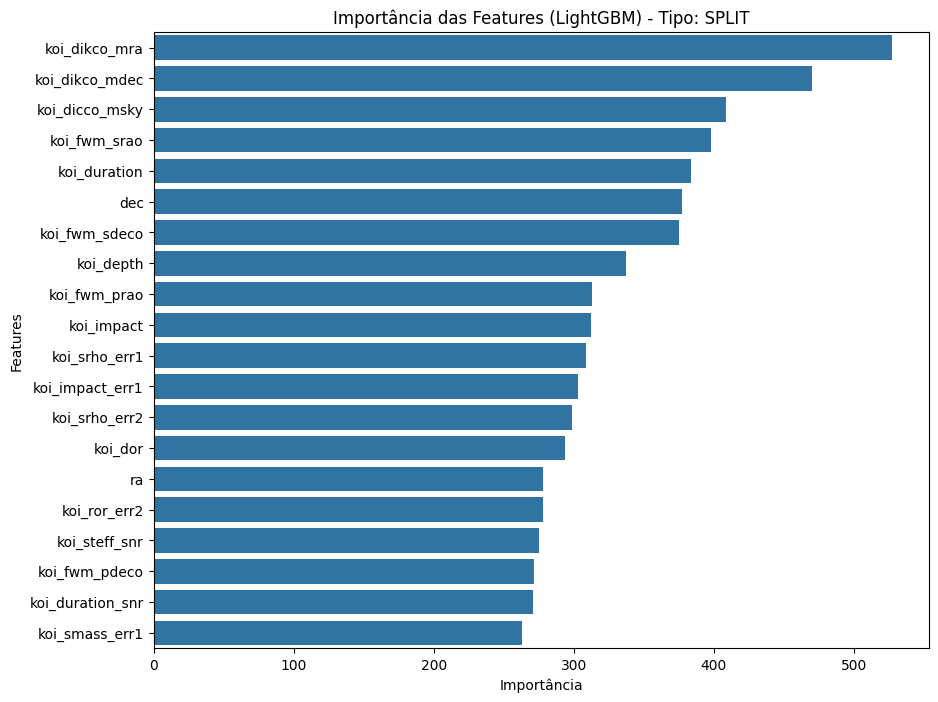

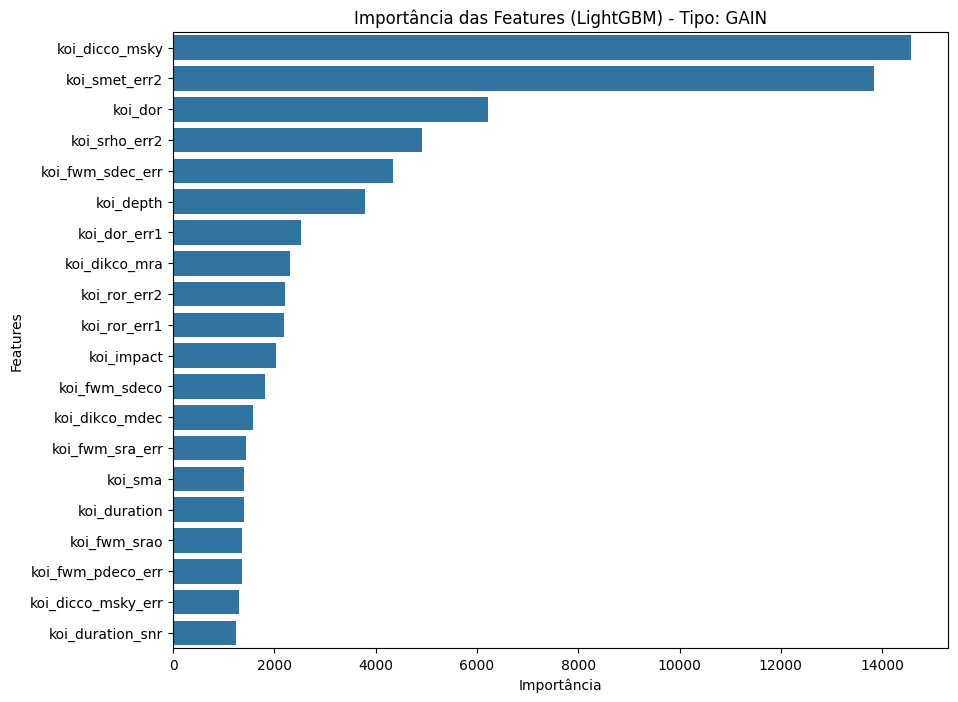

In [163]:
# %% [markdown]
# ### 1.1. Usando a Feature Importance Embutida do Modelo
# 
# Esta é a maneira mais rápida e direta de obter a importância das features. Os modelos baseados em árvores calculam isso durante o treinamento.
# 
# * **Gain (Padrão):** A contribuição média de cada feature para a redução do erro do modelo. **É a métrica mais confiável.**
# * **Weight (Split Count):** O número de vezes que uma feature foi usada para dividir um nó.
# * **Cover:** O número médio de amostras que são afetadas por uma divisão que usa a feature.

# %%
import seaborn as sns
def plot_feature_importance(importance, names, model_type, importance_type):
    """Função para plotar a importância das features."""
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df = fi_df.head(20) # Mostra apenas as 20 features mais importantes

    plt.figure(figsize=(10, 8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(f'Importância das Features ({model_type}) - Tipo: {importance_type.upper()}')
    plt.xlabel('Importância')
    plt.ylabel('Features')
    plt.show()

# Verifica se o melhor modelo é XGBoost ou LightGBM para usar suas funções nativas
if isinstance(best_model, XGBClassifier):
    print("--- Importância para XGBoost ---")
    # Plotando os diferentes tipos de importância para XGBoost
    plot_feature_importance(best_model.feature_importances_, X.columns, 'XGBoost', 'gain') # Padrão é 'gain'
    
    # Para ver outros tipos, precisamos acessar a API nativa do Booster
    booster = best_model.get_booster()
    importance_weight = booster.get_score(importance_type='weight')
    plot_feature_importance(list(importance_weight.values()), list(importance_weight.keys()), 'XGBoost', 'weight')
    
    importance_cover = booster.get_score(importance_type='cover')
    plot_feature_importance(list(importance_cover.values()), list(importance_cover.keys()), 'XGBoost', 'cover')

elif isinstance(best_model, LGBMClassifier):
    print("--- Importância para LightGBM ---")
    # Plotando os diferentes tipos de importância para LightGBM
    plot_feature_importance(best_model.feature_importances_, X.columns, 'LightGBM', 'split') # Padrão é 'split'
    
    # Trocando para 'gain'
    best_model.importance_type = 'gain'
    plot_feature_importance(best_model.feature_importances_, X.columns, 'LightGBM', 'gain')


Calculando os valores SHAP... (Isso pode levar alguns minutos)


c:\Users\Guilherme\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
C:\Users\Guilherme\AppData\Local\Temp\ipykernel_11612\2281235239.py:25: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X, plot_type="dot", show=False)


Cálculo do SHAP concluído!


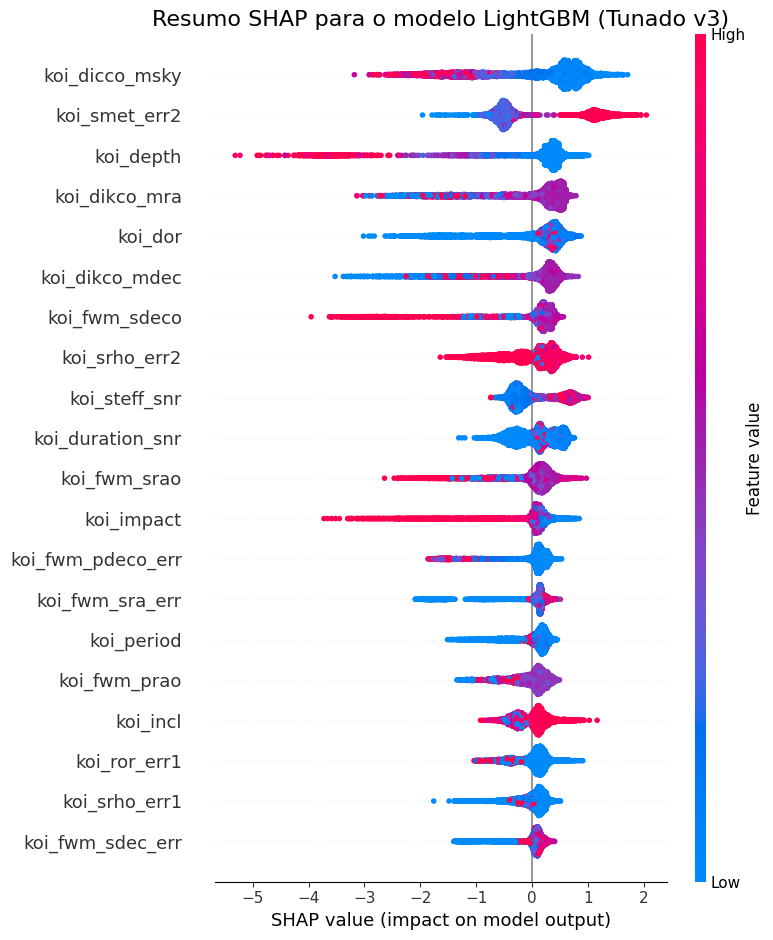

C:\Users\Guilherme\AppData\Local\Temp\ipykernel_11612\2281235239.py:32: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X, plot_type="bar", show=False)


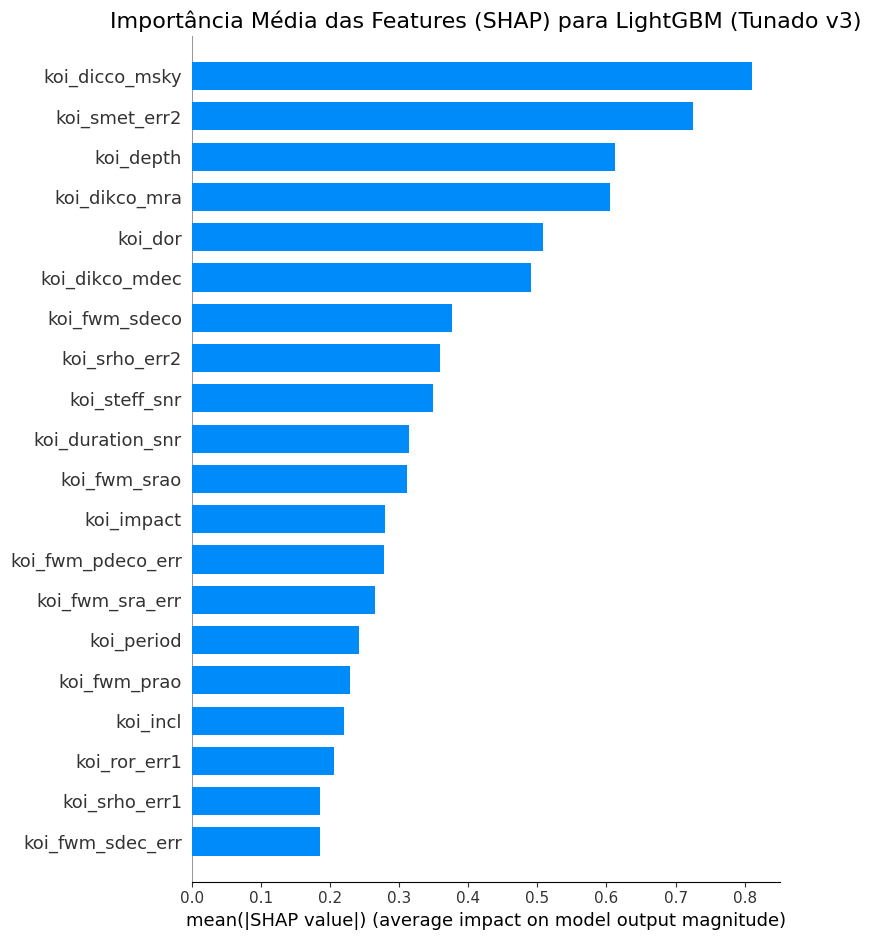

In [164]:
# %% [markdown]
# ### 1.2. Usando SHAP (SHapley Additive exPlanations)
# 
# SHAP é considerado o estado da arte para interpretabilidade. Ele fornece uma visão muito mais rica, mostrando não apenas a importância de cada feature, mas também a direção do seu impacto.
# 
# O gráfico de resumo (beeswarm) abaixo mostra:
# * **Eixo Y:** As features, ordenadas pela sua importância global.
# * **Eixo X:** O valor SHAP. Valores positivos "empurram" a previsão para a classe 1 (Planeta), e valores negativos empurram para a classe 0 (Falso Positivo).
# * **Cor:** O valor original da feature (vermelho = alto, azul = baixo).
import shap
# %%
# SHAP requer um pouco mais de tempo de processamento
print("\nCalculando os valores SHAP... (Isso pode levar alguns minutos)")

# Usamos o TreeExplainer, que é otimizado para modelos baseados em árvores
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_scaled_final)

print("Cálculo do SHAP concluído!")

# %%
# Plot do Resumo SHAP (Beeswarm Plot)
# Este gráfico é extremamente informativo
plt.title(f'Resumo SHAP para o modelo {best_model_name}', fontsize=16)
shap.summary_plot(shap_values, X, plot_type="dot", show=False)
plt.show()

# %%
# Plot do Resumo SHAP (Gráfico de Barras)
# Este gráfico mostra a importância global média de cada feature
plt.title(f'Importância Média das Features (SHAP) para {best_model_name}', fontsize=16)
shap.summary_plot(shap_values, X, plot_type="bar", show=False)
plt.show()